In [1]:
# Import Python libraries for visualisation and data analysis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
# 設定 seaborn 主題，這會影響圖表的風格和顏色
sns.set_theme()  # Apply the default Seaborn theme
%matplotlib inline
# Libraries for statistical and scientific computing
import statsmodels.api as sm
from scipy import stats

In [2]:
## Load packages
import tensorflow as tf
from tensorflow import keras
import tensorflow.python.keras.backend as K
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from keras import backend
import numpy as np
import matplotlib.pyplot as plt

from pandas import read_csv
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import pandas as pd

讀取含有chronos預測test的檔案

In [3]:
# 使用pandas讀取CSV文件
new_predict_data_id9 = pd.read_csv('https://raw.githubusercontent.com/xc90529/noninvasiv_visualization/main/DATA%20SET/new_predict_data_id9.csv')

new_predict_data_id9.head(5)

#SVI - 舒張容積指數
#SVV - 舒張容積變異度
#SVRI - 舒張容積指數阻力
#PR - 脈搏率 #SYS - 收縮壓 PR/SYS休克指數

,time,PR/SYS,SVV,SVI,SVRI
0,120.00000,0.85714,19.0,29.0,2260.86957
1,120.33333,0.85714,19.0,29.0,2260.86957
2,120.66667,0.85714,19.0,29.0,2260.86957
3,121.00000,0.85714,19.0,29.0,2260.86957
4,121.33333,0.85714,19.0,29.0,2260.86957


In [4]:
# 將 'time' 設置為索引
new_predict_data_id9.set_index('time', inplace=True)

# 提取需要的列
new_predict_data_id9 = new_predict_data_id9[['PR/SYS','SVV', 'SVI', 'SVRI']]

# 查看提取後的結果
new_predict_data_id9

,PR/SYS,SVV,SVI,SVRI
time,,,,
120.00000,0.857140,19.0,29.0,2260.86957
120.33333,0.857140,19.0,29.0,2260.86957
120.66667,0.857140,19.0,29.0,2260.86957
121.00000,0.857140,19.0,29.0,2260.86957
121.33333,0.857140,19.0,29.0,2260.86957
...,...,...,...,...
1392.00000,0.781677,26.0,28.0,2971.42857
1392.33333,0.781589,17.0,24.0,3022.22222
1392.66667,0.781501,17.0,24.0,3022.22222


讀取id9真實值檔案

In [5]:
# 使用pandas讀取CSV文件
Actual_filled_data_id9 = pd.read_csv('https://raw.githubusercontent.com/xc90529/noninvasiv_visualization/4db9b9afe824fa63c150f457f7b954f173b82eaf/DATA%20SET/Actual_filled_data_id9.csv')
Actual_filled_data_id9.head(5)


#CO-心輸出量
#CI - 心輸出指數
#SV - 舒張容積
#SVI - 舒張容積指數
#SVV - 舒張容積變異度
#SVR - 舒張容積阻力
#SVRI - 舒張容積指數阻力
#PR - 脈搏率
#SYS - 收縮壓
#DIA - 舒張壓
#MAP - 平均動脈壓

,time,PR/SYS,SVV,SVI,SVRI
0,120.00000,0.85714,19.0,29.0,2260.86957
1,120.33333,0.85714,19.0,29.0,2260.86957
2,120.66667,0.85714,19.0,29.0,2260.86957
3,121.00000,0.85714,19.0,29.0,2260.86957
4,121.33333,0.85714,19.0,29.0,2260.86957


In [6]:
# 將 'time' 設置為索引
Actual_filled_data_id9.set_index('time', inplace=True)

# 提取需要的列
Actual_filled_data_id9 = Actual_filled_data_id9[['PR/SYS','SVV', 'SVI', 'SVRI']]

# 查看提取後的結果
Actual_filled_data_id9

,PR/SYS,SVV,SVI,SVRI
time,,,,
120.00000,0.85714,19.0,29.0,2260.86957
120.33333,0.85714,19.0,29.0,2260.86957
120.66667,0.85714,19.0,29.0,2260.86957
121.00000,0.85714,19.0,29.0,2260.86957
121.33333,0.85714,19.0,29.0,2260.86957
...,...,...,...,...
1392.00000,0.72115,26.0,28.0,2971.42857
1392.33333,0.79348,17.0,24.0,3022.22222
1392.66667,0.79348,17.0,24.0,3022.22222


開始LSTM模型建構

In [7]:
# 参数化验证集和测试集占总数据的比例
test_ratio = 0.4

# 计算各数据集的大小
total_size = len(new_predict_data_id9)
test_size = int(total_size * test_ratio)  # 測試集原始大小
val_size = int(test_size * 0.5)   


# 分割索引
test_start = total_size - test_size
val_start = test_start + val_size    

# 分割DataFrame為訓練集、驗證集、測試集
train_df = new_predict_data_id9.iloc[:test_start]
val_df = new_predict_data_id9.iloc[test_start:val_start]
test_df = new_predict_data_id9.iloc[val_start:]

# 檢查分割結果
print(f"訓練集大小：{len(train_df)}")
print(f"驗證集大小：{len(val_df)}")
print(f"測試集大小：{len(test_df)}")

訓練集大小：2293
驗證集大小：764
測試集大小：764


In [8]:
# 使用MinMaxScaler進行縮放
scaler = MinMaxScaler()
columns = train_df.columns

df_train = train_df.copy()
df_test = test_df.copy()
df_val = val_df.copy()
# 對訓練集的數值列進行擬合和轉換，用相同的scaler避免資料外洩
df_train[columns] = scaler.fit_transform(df_train[columns])
# 使用相同的scaler參數來轉換測試集和驗證集的數值列
df_test[columns] = scaler.transform(df_test[columns])
df_val[columns] = scaler.transform(df_val[columns])


In [9]:
#转换DataFrame为Numpy数组
data_train = np.array(df_train)
data_val = np.array(df_val)
data_test = np.array(df_test)



In [10]:
# 将值数组转换为数据集矩阵的函数
def create_dataset_multivariate(dataset, look_back=30):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        # 获取 look_back 步长的数据作为输入
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        # 获取目标变量，假设目标变量是数据集中所有变量的最后一个值
        dataY.append(dataset[i + look_back, 0])  # 假设第0列是目标变量
    return np.array(dataX), np.array(dataY)

In [11]:
look_back = 30
# 创建数据集
trainX, trainY = create_dataset_multivariate(data_train, look_back)
valX, valY = create_dataset_multivariate(data_val, look_back)
testX, testY = create_dataset_multivariate(data_test, look_back)



# 重塑输入数据以适应LSTM的输入要求 [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[2]))
valX = np.reshape(valX, (valX.shape[0], look_back, valX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], look_back, testX.shape[2]))


print("trainX shape:", trainX.shape)
print("trainY shape:", trainY.shape)
print("ValX shape:", valX.shape)
print("ValY shape:", valY.shape)
print("testX shape:", testX.shape)
print("testY shape:", testY.shape)


trainX shape: (2263, 30, 4)
trainY shape: (2263,)
ValX shape: (734, 30, 4)
ValY shape: (734,)
testX shape: (734, 30, 4)
testY shape: (734,)


In [12]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
import torch
from torch.utils.data import DataLoader
from torchmetrics import MeanAbsoluteError, MeanAbsolutePercentageError, MeanSquaredError
device = torch.device('cpu')



/Users/apple/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size, dropout, device):
        super(LSTMModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.dropout = dropout
        self.device = device

        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            batch_first=True
            )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(in_features=hidden_size, out_features=output_size)
        
        return
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        out, _ = self.lstm(x, (h0, c0))
        
        out = self.dropout(out)
        # out = out.contiguous().view(-1, self.hidden_size)
        out = out[:, -1, :]
        out = self.fc(out)
        return out


input_size = 4
hidden_size = 64
num_layers = 2
output_size = 1
batch_size = 128
drop_rate = 0.3
device = torch.device('cpu')
model = LSTMModel(
    input_size=input_size, 
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
    batch_size=batch_size,
    dropout=drop_rate,
    device=device
).to(device)
model

LSTMModel(
  (lstm): LSTM(4, 64, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [14]:
# 轉換資料至Tensor
X_train_tensor = torch.from_numpy(trainX.astype(np.float32))
X_val_tensor = torch.from_numpy(valX.astype(np.float32))
X_test_tensor = torch.from_numpy(testX.astype(np.float32))


y_train_tensor = torch.from_numpy(trainY.astype(np.float32).reshape(-1, 1))
y_val_tensor = torch.from_numpy(valY.astype(np.float32).reshape(-1, 1))
y_test_tensor = torch.from_numpy(testY.astype(np.float32).reshape(-1, 1))


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    drop_last=True,
    shuffle=True
)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    drop_last = True,
    shuffle=False
)

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

n_past = 30
input_size = 4
output_size = 1

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

train_loss_arr = []
val_loss_arr = []

for epoch in range(75):
    model.train()
    train_loss = []
    val_loss = []

    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.reshape(-1, n_past, input_size).to(device)
        labels = labels.reshape(-1, output_size).to(device)
        
        outputs = model(inputs)
        optimizer.zero_grad()
        loss = criterion(outputs, labels)
        loss.backward()
        train_loss.append(loss.item())
        optimizer.step()

    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.reshape(-1, n_past, input_size).to(device)
            labels = labels.reshape(-1, output_size).to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss.append(loss.item())

    epoch_train_loss = sum(train_loss)/len(train_loss)
    epoch_val_loss = sum(val_loss)/len(val_loss)

    train_loss_arr.append(epoch_train_loss)
    val_loss_arr.append(epoch_val_loss)

    print(f'Epoch [{epoch+1}/{75}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')

Epoch [1/75], Train Loss: 0.1626, Val Loss: 0.0383
Epoch [2/75], Train Loss: 0.0469, Val Loss: 0.0397
Epoch [3/75], Train Loss: 0.0369, Val Loss: 0.0424
Epoch [4/75], Train Loss: 0.0293, Val Loss: 0.0242
Epoch [5/75], Train Loss: 0.0212, Val Loss: 0.0200
Epoch [6/75], Train Loss: 0.0198, Val Loss: 0.0214
Epoch [7/75], Train Loss: 0.0199, Val Loss: 0.0181
Epoch [8/75], Train Loss: 0.0179, Val Loss: 0.0174
Epoch [9/75], Train Loss: 0.0179, Val Loss: 0.0174
Epoch [10/75], Train Loss: 0.0175, Val Loss: 0.0175
Epoch [11/75], Train Loss: 0.0168, Val Loss: 0.0161
Epoch [12/75], Train Loss: 0.0170, Val Loss: 0.0160
Epoch [13/75], Train Loss: 0.0157, Val Loss: 0.0154
Epoch [14/75], Train Loss: 0.0159, Val Loss: 0.0150
Epoch [15/75], Train Loss: 0.0162, Val Loss: 0.0150
Epoch [16/75], Train Loss: 0.0155, Val Loss: 0.0151
Epoch [17/75], Train Loss: 0.0154, Val Loss: 0.0143
Epoch [18/75], Train Loss: 0.0154, Val Loss: 0.0144
Epoch [19/75], Train Loss: 0.0151, Val Loss: 0.0136
Epoch [20/75], Train 

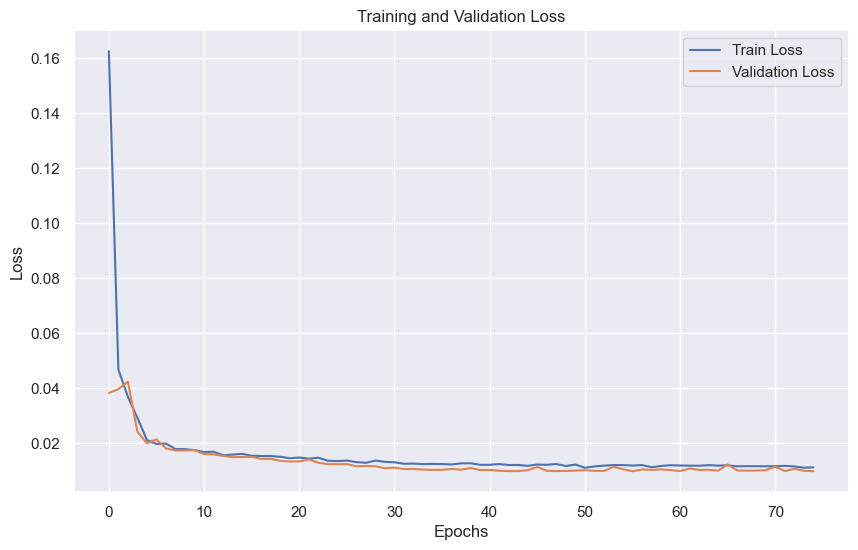

In [16]:
import matplotlib.pyplot as plt

# 确保在notebook中可以显示图像
%matplotlib inline

# 绘制训练损失和验证损失
plt.figure(figsize=(10, 6))  # 设置图像大小
plt.plot(train_loss_arr, label='Train Loss')  # 绘制训练损失
plt.plot(val_loss_arr, label='Validation Loss')  # 绘制验证损失
plt.title('Training and Validation Loss')  # 图像标题
plt.xlabel('Epochs')  # x轴标签
plt.ylabel('Loss')  # y轴标签
plt.legend()  # 显示图例
plt.show()  # 显示图像


In [17]:
import torch
import numpy as np

# 模型评估
model.eval()
with torch.no_grad():
    train_predicted = model(X_train_tensor.reshape(-1, n_past, input_size).to(device)).to('cpu')
    val_predicted = model(X_val_tensor.reshape(-1, n_past, input_size).to(device)).to('cpu')
    test_predicted = model(X_test_tensor.reshape(-1, n_past, input_size).to(device)).to('cpu')

# 反向缩放预测值
def inverse_transform(predictions, original_data, scaler):
    full_data = np.concatenate((predictions.numpy(), original_data[:, -1, 1:]), axis=1)
    inversed_data = scaler.inverse_transform(full_data)
    return inversed_data[:, 0]  # 只提取目标变量

trainPredict_inv = inverse_transform(train_predicted, trainX, scaler)
valPredict_inv = inverse_transform(val_predicted, valX, scaler)
testPredict_inv = inverse_transform(test_predicted, testX, scaler)

# 提取真实的 PR/SYS 值
true_values = Actual_filled_data_id9['PR/SYS'].values

# 获取 look_back 的值
look_back = 30

# 打印部分结果以检查
print("训练集预测（反向缩放）：", trainPredict_inv[:5])
print("验证集预测（反向缩放）：", valPredict_inv[:5])
print("测试集预测（反向缩放）：", testPredict_inv[:5])
print("真实 PR/SYS 值：", true_values[:5])


训练集预测（反向缩放）： [0.88045721 0.85315696 0.8958626  0.87889168 0.83386291]
验证集预测（反向缩放）： [0.93347296 0.75994762 0.7321217  0.71689081 0.73395719]
测试集预测（反向缩放）： [0.99901766 0.98769841 0.98772126 0.98749551 0.98722464]
真实 PR/SYS 值： [0.85714 0.85714 0.85714 0.85714 0.85714]


In [18]:
# 重置索引，使得'time'成为一个列
selected_features_df = Actual_filled_data_id9.reset_index()
if 'level_0' in selected_features_df.columns:
    selected_features_df = selected_features_df.drop(columns=['level_0'])
selected_features_df

,time,PR/SYS,SVV,SVI,SVRI
0,120.00000,0.85714,19.0,29.0,2260.86957
1,120.33333,0.85714,19.0,29.0,2260.86957
2,120.66667,0.85714,19.0,29.0,2260.86957
3,121.00000,0.85714,19.0,29.0,2260.86957
4,121.33333,0.85714,19.0,29.0,2260.86957
...,...,...,...,...,...
3816,1392.00000,0.72115,26.0,28.0,2971.42857
3817,1392.33333,0.79348,17.0,24.0,3022.22222
3818,1392.66667,0.79348,17.0,24.0,3022.22222
3819,1393.00000,0.81111,21.0,27.0,2760.00000


In [19]:
selected_features_df

,time,PR/SYS,SVV,SVI,SVRI
0,120.00000,0.85714,19.0,29.0,2260.86957
1,120.33333,0.85714,19.0,29.0,2260.86957
2,120.66667,0.85714,19.0,29.0,2260.86957
3,121.00000,0.85714,19.0,29.0,2260.86957
4,121.33333,0.85714,19.0,29.0,2260.86957
...,...,...,...,...,...
3816,1392.00000,0.72115,26.0,28.0,2971.42857
3817,1392.33333,0.79348,17.0,24.0,3022.22222
3818,1392.66667,0.79348,17.0,24.0,3022.22222
3819,1393.00000,0.81111,21.0,27.0,2760.00000


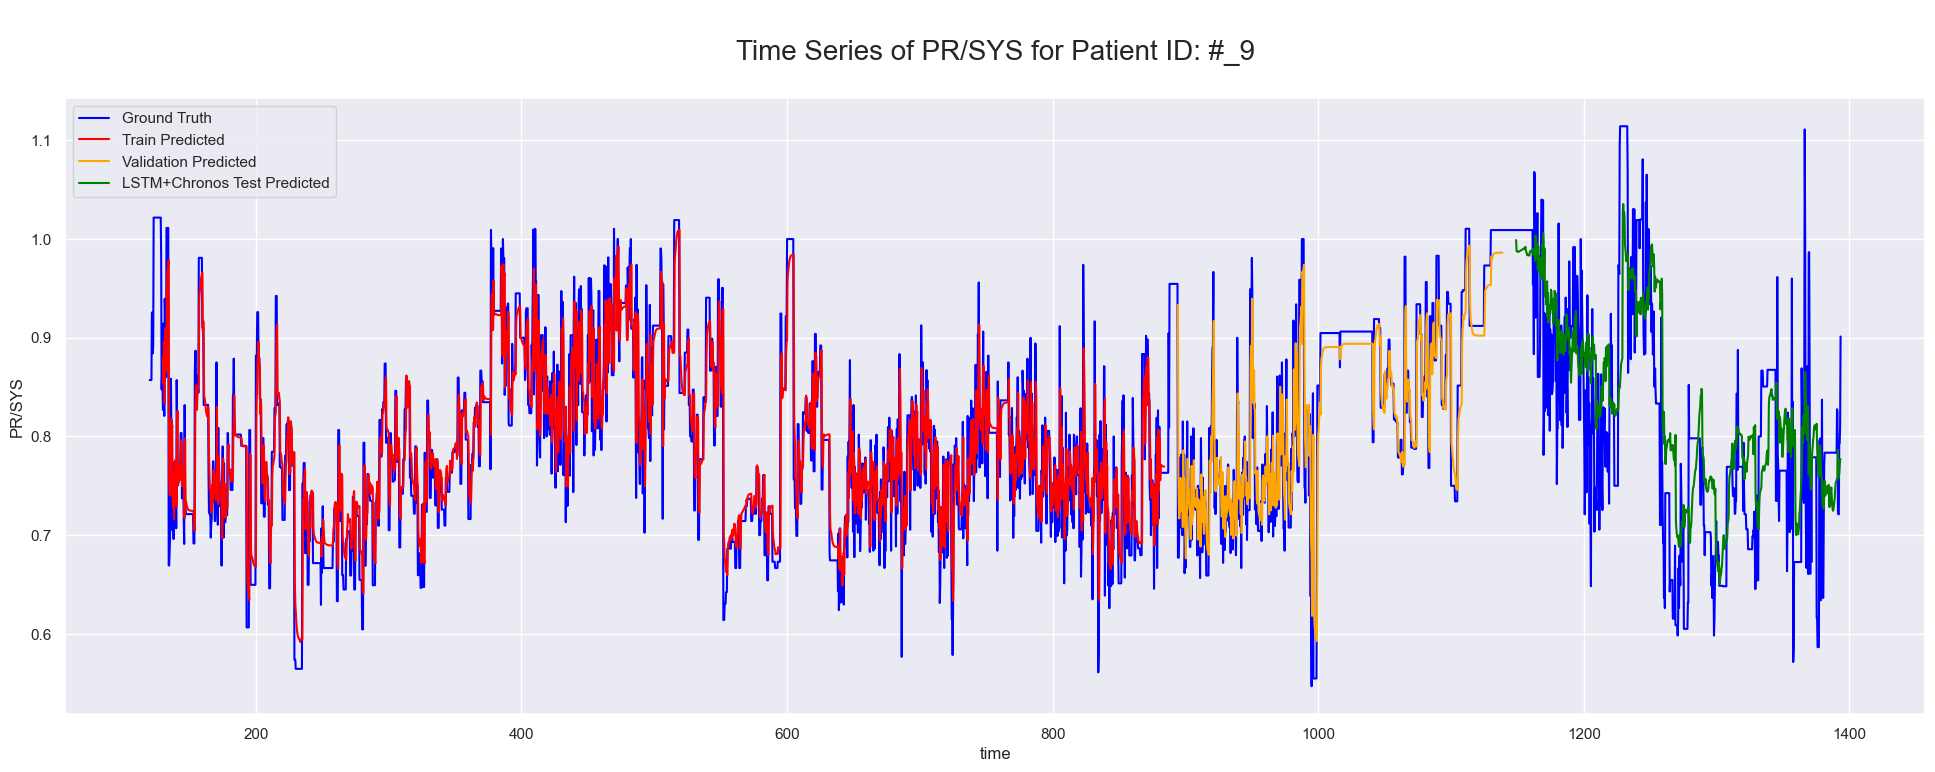

In [20]:
# 调整时间序列以考虑 look_back 周期
X_train_time = selected_features_df['time'][look_back:look_back + len(train_predicted)]
X_val_time = selected_features_df['time'][look_back + len(train_predicted) + look_back:look_back + len(train_predicted) + look_back + len(val_predicted)]
X_test_time = selected_features_df['time'][look_back + len(train_predicted) + look_back + len(val_predicted) + look_back:look_back + len(train_predicted) + look_back + len(val_predicted) + look_back + len(test_predicted)]

# 创建预测值的数据框
# 将预测值与时间信息组合成DataFrame
train_predictions_df = pd.DataFrame({'time': X_train_time, 'PR/SYS': trainPredict_inv.squeeze()})
val_predictions_df = pd.DataFrame({'time': X_val_time, 'PR/SYS': valPredict_inv.squeeze()})
test_predictions_df = pd.DataFrame({'time': X_test_time, 'PR/SYS': testPredict_inv.squeeze()})

# 使用Seaborn绘制真实值
sns.set(rc={'figure.figsize':(24,8)})
ax = sns.lineplot(data=selected_features_df, x='time', y='PR/SYS', label='Ground Truth', color='blue')

# 添加预测结果的线性图层
sns.lineplot(data=train_predictions_df, x='time', y='PR/SYS', ax=ax, label='Train Predicted', color='red')
sns.lineplot(data=val_predictions_df, x='time', y='PR/SYS', ax=ax, label='Validation Predicted', color='orange')
sns.lineplot(data=test_predictions_df, x='time', y='PR/SYS', ax=ax, label='LSTM+Chronos Test Predicted', color='green')

# 设置标题
ax.set_title("\nTime Series of PR/SYS for Patient ID: #_9\n", fontsize=20)

# 显示图例
plt.legend()
plt.show()

In [21]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torchmetrics
from torchmetrics import MeanAbsoluteError, MeanAbsolutePercentageError, MeanSquaredError
# 提取与预测值对齐的真实值
train_true_values = true_values[look_back:look_back + len(train_predicted)]
val_true_values = true_values[look_back + len(train_predicted) + look_back:look_back + len(train_predicted) + look_back + len(val_predicted)]
test_true_values = true_values[look_back + len(train_predicted) + look_back + len(val_predicted) + look_back:look_back + len(train_predicted) + look_back + len(val_predicted) + look_back + len(test_predicted)]

# 将 numpy.ndarray 转换为 torch.Tensor
train_true_values_tensor = torch.tensor(train_true_values, dtype=torch.float32)
trainPredict_inv_tensor = torch.tensor(trainPredict_inv, dtype=torch.float32)
val_true_values_tensor = torch.tensor(val_true_values, dtype=torch.float32)
valPredict_inv_tensor = torch.tensor(valPredict_inv, dtype=torch.float32)
test_true_values_tensor = torch.tensor(test_true_values, dtype=torch.float32)
testPredict_inv_tensor = torch.tensor(testPredict_inv, dtype=torch.float32)

# 使用 torchmetrics 计算 MAE 和 RMSE
mae_metric = torchmetrics.MeanAbsoluteError()
rmse_metric = torchmetrics.MeanSquaredError(squared=False)
mape_metric = MeanAbsolutePercentageError()

# 使用 torchmetrics 计算 MAE、RMSE 和 MAPE
mae_metric = torchmetrics.MeanAbsoluteError()
rmse_metric = torchmetrics.MeanSquaredError(squared=False)
mape_metric = torchmetrics.MeanAbsolutePercentageError()

# 计算训练集的 MAE、RMSE 和 MAPE
train_mae = round(mae_metric(trainPredict_inv_tensor, train_true_values_tensor).item() * 100, 2)
train_rmse = round(rmse_metric(trainPredict_inv_tensor, train_true_values_tensor).item() * 100, 2)
train_mape = round(mape_metric(trainPredict_inv_tensor, train_true_values_tensor).item() * 100, 2)

print(f"Train MAE: {train_mae}%")
print(f"Train RMSE: {train_rmse}%")
print(f"Train MAPE: {train_mape}%")

# 计算验证集的 MAE、RMSE 和 MAPE
val_mae = round(mae_metric(valPredict_inv_tensor, val_true_values_tensor).item() * 100, 2)
val_rmse = round(rmse_metric(valPredict_inv_tensor, val_true_values_tensor).item() * 100, 2)
val_mape = round(mape_metric(valPredict_inv_tensor, val_true_values_tensor).item() * 100, 2)

print(f"Validation MAE: {val_mae}%")
print(f"Validation RMSE: {val_rmse}%")
print(f"Validation MAPE: {val_mape}%")

# 计算测试集的 MAE、RMSE 和 MAPE
test_mae = round(mae_metric(testPredict_inv_tensor, test_true_values_tensor).item() * 100, 2)
test_rmse = round(rmse_metric(testPredict_inv_tensor, test_true_values_tensor).item() * 100, 2)
test_mape = round(mape_metric(testPredict_inv_tensor, test_true_values_tensor).item() * 100, 2)

print(f"Test MAE: {test_mae}%")
print(f"Test RMSE: {test_rmse}%")
print(f"Test MAPE: {test_mape}%")

Train MAE: 3.02%
Train RMSE: 4.48%
Train MAPE: 3.92%
Validation MAE: 2.95%
Validation RMSE: 4.4%
Validation MAPE: 3.67%
Test MAE: 6.59%
Test RMSE: 8.25%
Test MAPE: 8.46%


In [22]:
test_predictions_df

,time,PR/SYS
3087,1149.00000,0.999018
3088,1149.33333,0.987698
3089,1149.66667,0.987721
3090,1150.00000,0.987496
3091,1150.33333,0.987225
...,...,...
3816,1392.00000,0.761533
3817,1392.33333,0.761772
3818,1392.66667,0.770309
3819,1393.00000,0.776494


In [23]:
selected_features_df

,time,PR/SYS,SVV,SVI,SVRI
0,120.00000,0.85714,19.0,29.0,2260.86957
1,120.33333,0.85714,19.0,29.0,2260.86957
2,120.66667,0.85714,19.0,29.0,2260.86957
3,121.00000,0.85714,19.0,29.0,2260.86957
4,121.33333,0.85714,19.0,29.0,2260.86957
...,...,...,...,...,...
3816,1392.00000,0.72115,26.0,28.0,2971.42857
3817,1392.33333,0.79348,17.0,24.0,3022.22222
3818,1392.66667,0.79348,17.0,24.0,3022.22222
3819,1393.00000,0.81111,21.0,27.0,2760.00000


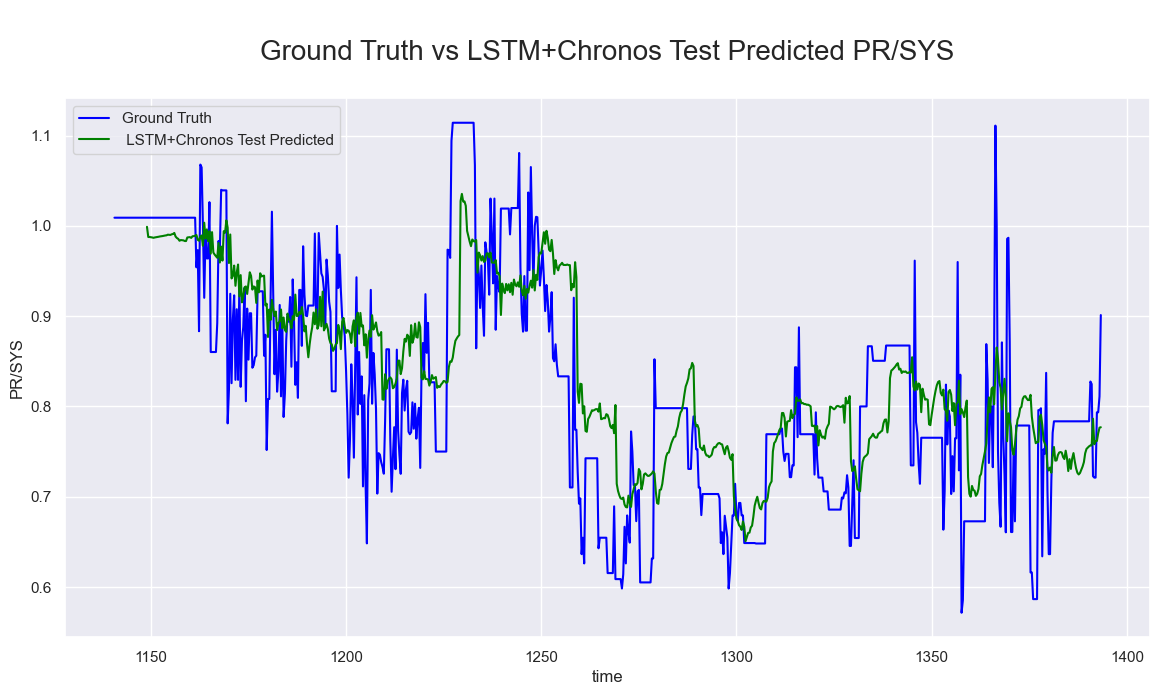

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 'PR/SYS' 是第一列
column_index = selected_features_df.columns.get_loc('PR/SYS')

# 将预测值与时间信息组合成 DataFrame
train_predictions_df = pd.DataFrame({'time': X_train_time, 'PR/SYS': trainPredict_inv})
val_predictions_df = pd.DataFrame({'time': X_val_time, 'PR/SYS': valPredict_inv})
test_predictions_df = pd.DataFrame({'time': X_test_time, 'PR/SYS': testPredict_inv})

# 绘制单独的真值与测试集对比图（缩小时间范围）
sns.set(rc={'figure.figsize':(14, 7)})

# 设置要显示的时间范围，调整时间范围以显示更多细节
time_min = 1140.66667
time_max = 1395.33333

# 过滤数据
selected_features_subset = selected_features_df[(selected_features_df['time'] >= time_min) & (selected_features_df['time'] <= time_max)]
test_predictions_subset = test_predictions_df[(test_predictions_df['time'] >= time_min) & (test_predictions_df['time'] <= time_max)]

# 绘制真实值
ax = sns.lineplot(data=selected_features_subset, x='time', y='PR/SYS', label='Ground Truth', color='blue')

# 添加测试集预测结果的线性图层
sns.lineplot(data=test_predictions_subset, x='time', y='PR/SYS', ax=ax, label=' LSTM+Chronos Test Predicted', color='green')

# 设置标题
ax.set_title("\nGround Truth vs LSTM+Chronos Test Predicted PR/SYS\n", fontsize=20)

# 显示图例
plt.legend()
plt.show()
